<a href="https://www.kaggle.com/code/ravaghi/s05e04-podcast-listening-time-ridge?scriptVersionId=236075855" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install ydf koolbox scikit-learn==1.5.2 && pip install --no-deps scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 71.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


# Imports and configs

In [2]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, TargetEncoder
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from scikeras.wrappers import KerasRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from ydf import GradientBoostedTreesLearner
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from koolbox import Trainer
import matplotlib.pyplot as plt
import contextlib, io
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import shutil
import optuna
import keras
import json
import glob
import ydf

ydf.verbose(2)
warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e4/train.csv"
    test_path = "/kaggle/input/playground-series-s5e4/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e4/sample_submission.csv"

    original_path = "/kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset.csv"
    
    target = "Listening_Time_minutes"
    metric = "RMSE"
    n_folds = 5
    seed = 42

    run_optuna = True
    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

cat_cols = test.select_dtypes(include="object").columns.tolist()
train[cat_cols] = train[cat_cols].astype(str).astype("category")
test[cat_cols] = test[cat_cols].astype(str).astype("category")

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

# Training base models

In [5]:
histgb_params = {
    "categorical_features": "from_dtype",
    "l2_regularization": 83.89023753261954,
    "learning_rate": 0.014076263018504506,
    "max_depth": 167,
    "max_features": 0.35671906170746404,
    "max_iter": 2175,
    "max_leaf_nodes": 441,
    "min_samples_leaf": 41,
    "random_state": 42
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.5099047573235393,
    "learning_rate": 0.04655222942419148,
    "min_child_samples": 39,
    "min_child_weight": 0.5763597850247795,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 94,
    "random_state": 42,
    "reg_alpha": 13.37124947203867,
    "reg_lambda": 3.4607082189282656,
    "subsample": 0.8594971769419172,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.44242724444333914,
    "learning_rate": 0.02648790357768195,
    "min_child_samples": 31,
    "min_child_weight": 0.565923097348698,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 91,
    "random_state": 42,
    "reg_alpha": 14.802741846604295,
    "reg_lambda": 3.285199583781151,
    "subsample": 0.4765616561570595,
    "verbose": -1
}

xgb_params = {
    "colsample_bylevel": 0.562776356802306,
    "colsample_bynode": 0.9612908685331664,
    "colsample_bytree": 0.6576899092549643,
    "early_stopping_rounds": 100,
    "enable_categorical": True,
    "eval_metric": "rmse",
    "gamma": 6.906307575453604,
    "learning_rate": 0.035818175355750034,
    "max_depth": 79,
    "max_leaves": 94,
    "min_child_weight": 54,
    "n_estimators": 10000,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 40.48896149819585,
    "reg_lambda": 50.48291846164928,
    "subsample": 0.987369044259711,
    "verbosity": 0
}

cb_params = {
    "border_count": 197,
    "colsample_bylevel": 0.5512194940746528,
    "depth": 10,
    "eval_metric": "RMSE",
    "iterations": 5000,
    "l2_leaf_reg": 0.8315140039900148,
    "learning_rate": 0.04835894985543038,
    "min_child_samples": 248,
    "random_state": 42,
    "random_strength": 0.269215705791639,
    "verbose": False
}

ydf_params = {
    "num_trees": 1000,
    "max_depth": 8
}

In [6]:
scores = {}
oof_preds = {}
test_preds = {}

## HistGradientBoosting

In [7]:
histgb_trainer = Trainer(
    HistGradientBoostingRegressor(**histgb_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=root_mean_squared_error,
    task="regression"
)

histgb_trainer.fit(X, y)

scores["HistGB"] = histgb_trainer.fold_scores
oof_preds["HistGB"] = histgb_trainer.oof_preds
test_preds["HistGB"] = histgb_trainer.predict(X_test)

Training HistGradientBoostingRegressor

--- Fold 0 - root_mean_squared_error: 12.7989 - Time: 261.07 s
--- Fold 1 - root_mean_squared_error: 12.8421 - Time: 249.00 s
--- Fold 2 - root_mean_squared_error: 12.8672 - Time: 190.05 s
--- Fold 3 - root_mean_squared_error: 12.8648 - Time: 183.15 s
--- Fold 4 - root_mean_squared_error: 12.8206 - Time: 217.16 s

------ Overall root_mean_squared_error: 12.8388 - Mean root_mean_squared_error: 12.8387 ± 0.0262 - Time: 1101.94 s


## LightGBM (gbdt)

In [8]:
lgbm_trainer = Trainer(
    LGBMRegressor(**lgbm_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=root_mean_squared_error,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "eval_metric": "rmse",
    "callbacks": [
        log_evaluation(period=500), 
        early_stopping(stopping_rounds=100)
    ]
}

lgbm_trainer.fit(X, y, fit_args)

scores["LightGBM (gbdt)"] = lgbm_trainer.fold_scores
oof_preds["LightGBM (gbdt)"] = lgbm_trainer.oof_preds
test_preds["LightGBM (gbdt)"] = lgbm_trainer.predict(X_test)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 12.9067	valid_0's l2: 166.584
[1000]	valid_0's rmse: 12.8612	valid_0's l2: 165.41
[1500]	valid_0's rmse: 12.8294	valid_0's l2: 164.594
[2000]	valid_0's rmse: 12.8137	valid_0's l2: 164.191
[2500]	valid_0's rmse: 12.7984	valid_0's l2: 163.798
[3000]	valid_0's rmse: 12.7847	valid_0's l2: 163.45
[3500]	valid_0's rmse: 12.7751	valid_0's l2: 163.203
[4000]	valid_0's rmse: 12.767	valid_0's l2: 162.997
[4500]	valid_0's rmse: 12.7573	valid_0's l2: 162.749
[5000]	valid_0's rmse: 12.7514	valid_0's l2: 162.598
[5500]	valid_0's rmse: 12.7485	valid_0's l2: 162.525
Early stopping, best iteration is:
[5613]	valid_0's rmse: 12.7473	valid_0's l2: 162.492
--- Fold 0 - root_mean_squared_error: 12.7473 - Time: 199.63 s

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 12.9716	valid_0's l2: 168.263
[1000]	valid_0's rmse: 12.9185	valid_0's l2: 166.887
[1500]	valid_0's

## LightGBM (goss)

In [9]:
lgbm_goss_trainer = Trainer(
    LGBMRegressor(**lgbm_goss_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=root_mean_squared_error,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "eval_metric": "rmse",
    "callbacks": [
        log_evaluation(period=500), 
        early_stopping(stopping_rounds=100)
    ]
}

lgbm_goss_trainer.fit(X, y, fit_args)

scores["LightGBM (goss)"] = lgbm_goss_trainer.fold_scores
oof_preds["LightGBM (goss)"] = lgbm_goss_trainer.oof_preds
test_preds["LightGBM (goss)"] = lgbm_goss_trainer.predict(X_test)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 12.9488	valid_0's l2: 167.672
[1000]	valid_0's rmse: 12.9096	valid_0's l2: 166.658
[1500]	valid_0's rmse: 12.8842	valid_0's l2: 166.002
[2000]	valid_0's rmse: 12.8672	valid_0's l2: 165.565
[2500]	valid_0's rmse: 12.8547	valid_0's l2: 165.242
[3000]	valid_0's rmse: 12.8451	valid_0's l2: 164.996
[3500]	valid_0's rmse: 12.837	valid_0's l2: 164.788
[4000]	valid_0's rmse: 12.8311	valid_0's l2: 164.638
[4500]	valid_0's rmse: 12.8253	valid_0's l2: 164.488
Early stopping, best iteration is:
[4746]	valid_0's rmse: 12.8235	valid_0's l2: 164.441
--- Fold 0 - root_mean_squared_error: 12.8235 - Time: 293.24 s

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 13.007	valid_0's l2: 169.182
[1000]	valid_0's rmse: 12.9597	valid_0's l2: 167.954
[1500]	valid_0's rmse: 12.9321	valid_0's l2: 167.239
[2000]	valid_0's rmse: 12.9129	valid_0's l2: 166.744
[2500]	valid_0'

## XGBoost

In [10]:
xgb_trainer = Trainer(
    XGBRegressor(**xgb_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=root_mean_squared_error,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "verbose": 500
}

xgb_trainer.fit(X, y, fit_args)

scores["XGBoost"] = xgb_trainer.fold_scores
oof_preds["XGBoost"] = xgb_trainer.oof_preds
test_preds["XGBoost"] = xgb_trainer.predict(X_test)

Training XGBRegressor

[0]	validation_0-rmse:26.44357
[500]	validation_0-rmse:12.97921
[1000]	validation_0-rmse:12.93159
[1500]	validation_0-rmse:12.90699
[2000]	validation_0-rmse:12.89058
[2500]	validation_0-rmse:12.88015
[3000]	validation_0-rmse:12.87023
[3500]	validation_0-rmse:12.86315
[4000]	validation_0-rmse:12.85884
[4500]	validation_0-rmse:12.85449
[4819]	validation_0-rmse:12.85271
--- Fold 0 - root_mean_squared_error: 12.8522 - Time: 634.20 s

[0]	validation_0-rmse:26.45530
[500]	validation_0-rmse:13.04837
[1000]	validation_0-rmse:12.99831
[1500]	validation_0-rmse:12.97191
[2000]	validation_0-rmse:12.95573
[2500]	validation_0-rmse:12.94093
[3000]	validation_0-rmse:12.92949
[3500]	validation_0-rmse:12.92185
[4000]	validation_0-rmse:12.91870
[4300]	validation_0-rmse:12.91746
--- Fold 1 - root_mean_squared_error: 12.9169 - Time: 564.90 s

[0]	validation_0-rmse:26.44687
[500]	validation_0-rmse:13.03355
[1000]	validation_0-rmse:12.98836
[1500]	validation_0-rmse:12.96566
[2000]	vali

## CatBoost

In [11]:
cb_trainer = Trainer(
    CatBoostRegressor(**cb_params, cat_features=cat_cols),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=root_mean_squared_error,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "verbose": 500,
    "early_stopping_rounds": 100,
    "use_best_model": True
}

cb_trainer.fit(X, y, fit_args)

scores["CatBoost"] = cb_trainer.fold_scores
oof_preds["CatBoost"] = cb_trainer.oof_preds
test_preds["CatBoost"] = cb_trainer.predict(X_test)

Training CatBoostRegressor

0:	learn: 26.1819970	test: 26.1655948	best: 26.1655948 (0)	total: 604ms	remaining: 50m 17s
500:	learn: 12.8142656	test: 13.0162874	best: 13.0162874 (500)	total: 4m 41s	remaining: 42m 9s
1000:	learn: 12.5042519	test: 12.9652732	best: 12.9652732 (1000)	total: 9m 31s	remaining: 38m 1s
1500:	learn: 12.2156296	test: 12.9379068	best: 12.9379068 (1500)	total: 14m 26s	remaining: 33m 39s
2000:	learn: 11.9557353	test: 12.9200571	best: 12.9200571 (2000)	total: 19m 21s	remaining: 29m
2500:	learn: 11.7053304	test: 12.9079992	best: 12.9078491 (2482)	total: 24m 26s	remaining: 24m 25s
3000:	learn: 11.4690021	test: 12.9005754	best: 12.9005754 (3000)	total: 29m 33s	remaining: 19m 41s
3500:	learn: 11.2450508	test: 12.8946031	best: 12.8944255 (3496)	total: 34m 41s	remaining: 14m 51s
4000:	learn: 11.0190011	test: 12.8890630	best: 12.8890627 (3999)	total: 39m 41s	remaining: 9m 54s
4500:	learn: 10.8162756	test: 12.8846719	best: 12.8846555 (4490)	total: 44m 45s	remaining: 4m 57s
St

## Yggdrasil

In [12]:
def YDFRegressor(learner_class):

    class YDFXRegressor(BaseEstimator, RegressorMixin):

        def __init__(self, params={}):
            self.params = params

        def fit(self, X, y):
            assert isinstance(X, pd.DataFrame)
            assert isinstance(y, pd.Series)
            target = y.name
            params = self.params.copy()
            params['label'] = target
            params['task'] = ydf.Task.REGRESSION
            X = pd.concat([X, y], axis=1)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                self.model = learner_class(**params).train(X)
            return self

        def predict(self, X):
            assert isinstance(X, pd.DataFrame)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                return self.model.predict(X)

    return YDFXRegressor

In [13]:
ydf_trainer = Trainer(
    YDFRegressor(GradientBoostedTreesLearner)(ydf_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=root_mean_squared_error,
    task="regression"
)

ydf_trainer.fit(X, y)

scores["Yggdrasil"] = ydf_trainer.fold_scores
oof_preds["Yggdrasil"] = ydf_trainer.oof_preds
test_preds["Yggdrasil"] = ydf_trainer.predict(X_test)

Training YDFXRegressor

--- Fold 0 - root_mean_squared_error: 12.9323 - Time: 144.86 s
--- Fold 1 - root_mean_squared_error: 13.0021 - Time: 122.83 s
--- Fold 2 - root_mean_squared_error: 12.9930 - Time: 169.46 s
--- Fold 3 - root_mean_squared_error: 12.9890 - Time: 156.42 s
--- Fold 4 - root_mean_squared_error: 12.9468 - Time: 134.55 s

------ Overall root_mean_squared_error: 12.9727 - Mean root_mean_squared_error: 12.9726 ± 0.0277 - Time: 729.63 s


## AutoGluon

In [14]:
oof_preds_files = glob.glob(f'/kaggle/input/s05e04-podcast-listening-time-autogluon/*_oof_preds_*.pkl')
test_preds_files = glob.glob(f'/kaggle/input/s05e04-podcast-listening-time-autogluon/*_test_preds_*.pkl')

ag_oof_preds = joblib.load(oof_preds_files[0])
ag_test_preds = joblib.load(test_preds_files[0])

ag_scores = []
split = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(X, y)
for _, val_idx in split:
    y_val = y[val_idx]
    y_preds = ag_oof_preds[val_idx]   
    score = root_mean_squared_error(y_preds, y_val)
    ag_scores.append(score)
    
oof_preds["AutoGluon"], test_preds["AutoGluon"], scores["AutoGluon"] = ag_oof_preds, ag_test_preds, ag_scores

## Neural network

In [15]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

In [16]:
X_test.loc[X_test["Episode_Length_minutes"] > 500, "Episode_Length_minutes"] = None

In [17]:
cat_cols = ['Podcast_Name', 'Episode_Title']
ohe_cols = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
num_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']

pipeline = make_pipeline(
    ColumnTransformer(
        [
            ('one-hot-encode', OneHotEncoder(drop='first', sparse_output=False, dtype=np.float32, handle_unknown='ignore'), ohe_cols),
            ('target-encode', make_pipeline(TargetEncoder(), FunctionTransformer(lambda x: x.astype(np.float32)), StandardScaler()), cat_cols),
            ('impute-nums', make_pipeline(SimpleImputer(strategy='mean'), FunctionTransformer(lambda x: x.astype(np.float32)), StandardScaler()), num_cols),
        ]
    )
).set_output(transform='pandas')

X = pipeline.fit_transform(X, y)
X_test = pipeline.transform(X_test)

In [18]:
def get_model(meta):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(meta["X_shape_"][1:]))
    model.add(keras.layers.Dense(256, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(128, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(1))
    return model

In [19]:
def scheduler(epoch, lr):    
    if epoch % 3 == 0 and epoch:
        return lr / 2
    return lr

nn_model = KerasRegressor(
    get_model,
    loss="mean_squared_error",
    random_state=CFG.seed,
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')],
    optimizer=keras.optimizers.AdamW(learning_rate=0.01),
    validation_batch_size=65536,
    validation_split=0.1,
    batch_size=1024,
    epochs=50, 
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_rmse', patience=7, restore_best_weights=True),
        keras.callbacks.LearningRateScheduler(scheduler)
    ]
)

In [20]:
nn_bag = BaggingRegressor(
    nn_model,
    n_estimators=5,
    random_state=CFG.seed,
)

In [21]:
nn_trainer = Trainer(
    nn_bag,
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=root_mean_squared_error,
    task="regression"
)

nn_trainer.fit(X, y)

scores["KerasANN"] = nn_trainer.fold_scores
oof_preds["KerasANN"] = nn_trainer.oof_preds
test_preds["KerasANN"] = nn_trainer.predict(X_test)

Training BaggingRegressor

--- Fold 0 - root_mean_squared_error: 13.1511 - Time: 647.82 s
--- Fold 1 - root_mean_squared_error: 13.2128 - Time: 671.13 s
--- Fold 2 - root_mean_squared_error: 13.2032 - Time: 518.24 s
--- Fold 3 - root_mean_squared_error: 13.1894 - Time: 607.38 s
--- Fold 4 - root_mean_squared_error: 13.1574 - Time: 558.74 s

------ Overall root_mean_squared_error: 13.1828 - Mean root_mean_squared_error: 13.1828 ± 0.0245 - Time: 3005.86 s


# Ensembling with Ridge

In [22]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [23]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [24]:
def objective(trial):    
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 10),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2)
    }
    
    trainer = Trainer(
        Ridge(**params),
        cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
        metric=root_mean_squared_error,
        task="regression",
        verbose=False
    )
    trainer.fit(X, y)
    
    return trainer.overall_score

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1)
    best_params = study.best_params

    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"]
    }
else:
    ridge_params = {
        "random_state": CFG.seed
    }

[I 2025-04-25 21:10:38,526] A new study created in memory with name: no-name-964a6f90-e893-4cb2-94ef-baefb21eb76d
[I 2025-04-25 21:10:50,231] Trial 1 finished with value: 12.61266755093004 and parameters: {'alpha': 8.225930984889358, 'tol': 0.00321180608798038}. Best is trial 1 with value: 12.61266755093004.
[I 2025-04-25 21:10:51,633] Trial 2 finished with value: 12.612667552239062 and parameters: {'alpha': 6.42658707792387, 'tol': 4.5632388353051804e-05}. Best is trial 1 with value: 12.61266755093004.
[I 2025-04-25 21:10:52,307] Trial 3 finished with value: 12.612667555540705 and parameters: {'alpha': 1.8893957171391806, 'tol': 0.00719350466821868}. Best is trial 1 with value: 12.61266755093004.
[I 2025-04-25 21:10:52,398] Trial 0 finished with value: 12.612667550882167 and parameters: {'alpha': 8.291742952388466, 'tol': 0.008642551982206838}. Best is trial 0 with value: 12.612667550882167.
[I 2025-04-25 21:11:07,545] Trial 4 finished with value: 12.61266755647006 and parameters: {'a

In [25]:
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42,
  "alpha": 9.99845770016328,
  "tol": 0.0077370188601915205
}


In [26]:
ridge_trainer = Trainer(
    Ridge(**ridge_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=root_mean_squared_error,
    task="regression"
)

ridge_trainer.fit(X, y)

scores["Ridge (ensemble)"] = ridge_trainer.fold_scores
ridge_test_preds = ridge_trainer.predict(X_test)

Training Ridge

--- Fold 0 - root_mean_squared_error: 12.5786 - Time: 0.14 s
--- Fold 1 - root_mean_squared_error: 12.6512 - Time: 0.13 s
--- Fold 2 - root_mean_squared_error: 12.6180 - Time: 0.13 s
--- Fold 3 - root_mean_squared_error: 12.6368 - Time: 0.13 s
--- Fold 4 - root_mean_squared_error: 12.5786 - Time: 0.13 s

------ Overall root_mean_squared_error: 12.6127 - Mean root_mean_squared_error: 12.6126 ± 0.0297 - Time: 3.53 s


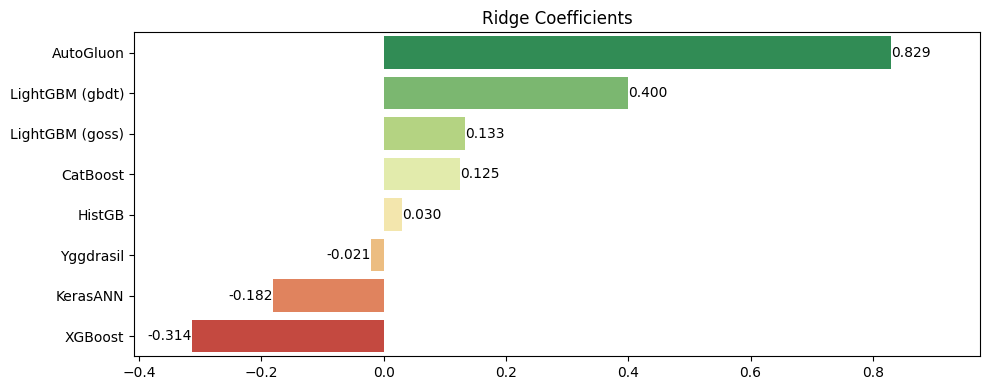

In [27]:
ridge_coeffs = np.zeros((1, X.shape[1]))
for m in ridge_trainer.estimators:
    ridge_coeffs += m.coef_
ridge_coeffs = ridge_coeffs / len(ridge_trainer.estimators)

plot_weights(ridge_coeffs, "Ridge Coefficients")

# Submission

In [28]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = ridge_test_preds
sub.to_csv(f"sub_ridge_{np.mean(scores['Ridge (ensemble)']):.6f}.csv", index=False)
sub.head()

,id,Listening_Time_minutes
0,750000,54.480376
1,750001,18.520390
2,750002,49.743580
3,750003,77.495366
4,750004,47.258422


# Results

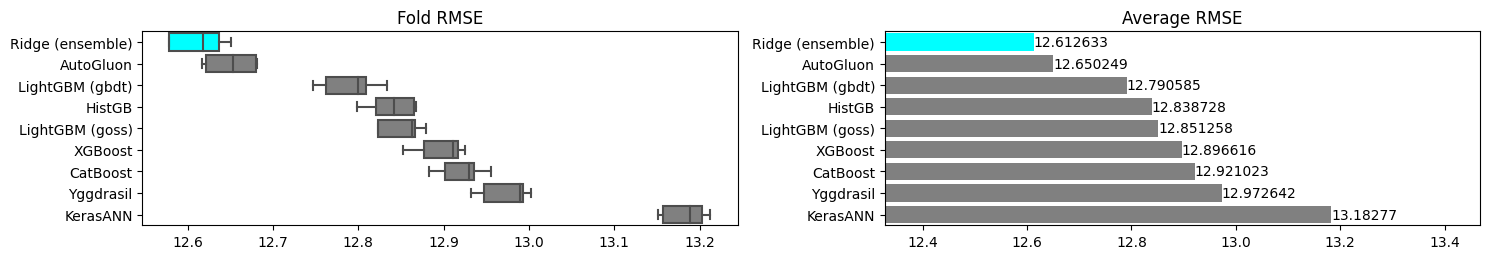

In [29]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold {CFG.metric}")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Average {CFG.metric}")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

In [30]:
shutil.rmtree("catboost_info", ignore_errors=True)